## TEST TO SEE IF THIS WORKS ON LARGER DATASET 

# Well Level Produced Gas
### Author: Monique Beaulieu

This notebook provides a complete workflow for estimating well-level produced gas rates from pad-level produced gas data and well event logs from pg_draft2.ipynb (well_event_pg_values.csv). It includes data loading, preprocessing, calculation of well-level produced gas values, and dashboard-style visualizations. The workflow is modular for clarity and reusability.

The logic for calculating well-level produced gas is based on the assumption that changes in pad-level produced gas following well events (such as trips, starts, or NFEs) can be attributed to the wells involved in those events. For example, a drop in pad produced gas after a well trips is attributed to that well, while an increase after a well starts is attributed to the starting well.

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Utility Functions

In [ ]:

def extract_pad(well):
    """
    Extracts the pad identifier from a well name using pattern matching.

    Parameters:
        well (str): Well name string.

    Returns:
        str: Pad identifier as a string.
    """
    # If well starts with 2 digits and 1 letter (e.g. '15W'), pad = '1' + digits (-> '115')
    m1 = re.match(r'^(\d{2})([A-Za-z])', well)
    if m1:
        return '1' + m1.group(1)
    # If well starts with 2 digits, 2 letters, and 1 digit (e.g. '7WP'), pad = '1' + digits (-> '107')
    m2 = re.match(r'^(\d)([A-Za-z]{2})', well)
    if m2:
        return '10' + m2.group(1)
    # If well starts with 2 digits, 1 letter, 1 letter, and 1 digit (e.g. '16W'), pad = '1' + digits (-> '116')
    m3 = re.match(r'^(\d{2})([A-Za-z]{1})', well)
    if m3:
        return '1' + m3.group(1)
    # If well starts with 3 digits (e.g. '106W13'), pad = those digits
    m4 = re.match(r'^(\d{3})', well)
    if m4:
        return m4.group(1)
    # Otherwise, fallback to first 3 chars
    return well[:3]

In [ ]:

def filter_target_pads(df, target_pads=None):
    """
    Filters the input DataFrame to only include rows corresponding to the specified pads.

    Parameters:
        df (pd.DataFrame): DataFrame containing well event data with a 'pad' column.
        target_pads (list, optional): List of pad identifiers to keep. Defaults to ['105', '106', '107', '108', '116'].

    Returns:
        pd.DataFrame: Filtered DataFrame containing only target pads.
    """
    if target_pads is None:
        target_pads = ['105', '106', '107', '108', '116']
    return df[df['pad'].astype(str).isin(target_pads)].reset_index(drop=True)


In [ ]:
def estimate_well_pg_actual(df_pad):
    """
    Calculates the actual produced gas value for each well event from aggregate pad-level data and timing.
    - Trip or NFE: The delta in produced gas value at the pad just before and after the event is attributed to that well (negative delta)
    - Starts: The delta in produced gas value at the pad just before and after the event is attributed to that well (positive delta)
    - Filtering: The produced gas delta's are converted to actual. Only positive values are considered valid.

    Parameters:
        df_pad (pd.DataFrame): DataFrame of well events for a single pad, must include 'pad_pg_value'.

    Returns:
        pd.DataFrame: DataFrame with columns ['pad', 'well', 'event_type', 'timestamp', 'produced_gas_value'].
    """
    results = []
    events = df_pad.sort_values('timestamp').reset_index(drop=True)
    for i, row in events.iterrows():
        well = row['well']
        event_type = row['event_type'].lower()
        ts = row['timestamp']
        pg_before = row['pad_pg_value']
        pg_after = events.loc[i + 1, 'pad_pg_value'] if i + 1 < len(events) else None
        if 'trip' in event_type or 'nfe' in event_type:
            produced_gas = pg_before
        elif 'start' in event_type and pg_after is not None:
            produced_gas = pg_after
        else:
            produced_gas = None
        if produced_gas is not None and produced_gas > 0:
            results.append({
                'pad': row['pad'],
                'well': well,
                'event_type': row['event_type'],
                'timestamp': ts,
                'produced_gas_value': produced_gas
            })
    return pd.DataFrame(results)

In [ ]:
def get_well_stats(df):
    """
    Aggregates well-level produced gas statistics and categorizes wells.

    Parameters:
        df (pd.DataFrame): DataFrame with well-level produced gas values.

    Returns:
        pd.DataFrame: DataFrame with columns ['well', 'mean', 'min', 'max', 'category'].
    """
    stats = df.groupby('well')['produced_gas_value'].agg(['mean', 'min', 'max']).reset_index()
    stats = stats.sort_values('mean', ascending=False).reset_index(drop=True)
    stats = stats.round(2)
    n_wells = len(stats)
    top_cutoff = int(n_wells * 0.2)
    bottom_cutoff = int(n_wells * 0.8)
    stats['category'] = 'Medium'
    stats.loc[:top_cutoff-1, 'category'] = 'Top 20%'
    stats.loc[bottom_cutoff:, 'category'] = 'Bottom 20%'
    return stats

In [ ]:
def get_pad_stats(df):
    """
    Aggregates pad-level produced gas statistics and categorizes pads.

    Parameters:
        df (pd.DataFrame): DataFrame with pad-level produced gas values.

    Returns:
        pd.DataFrame: DataFrame with columns ['pad', 'mean', 'min', 'max', 'category'].
    """
    stats = df.groupby('pad')['produced_gas_value'].agg(['mean', 'min', 'max']).reset_index()
    stats = stats.sort_values('mean', ascending=False).reset_index(drop=True)
    stats = stats.round(2)
    n_pads = len(stats)
    top_cutoff = int(n_pads * 0.2)
    bottom_cutoff = int(n_pads * 0.8)
    stats['category'] = 'Medium'
    stats.loc[:top_cutoff-1, 'category'] = 'Top 20%'
    stats.loc[bottom_cutoff:, 'category'] = 'Bottom 20%'
    return stats

In [ ]:
def plot_pad_well_dashboard(df):
    """
    Creates dashboard-style visualizations for each pad, showing well produced gas distributions and summary tables.

    Parameters:
        df (pd.DataFrame): DataFrame with well-level produced gas values.

    Returns:
        None
    """
    pad_list = df['pad'].unique()
    n_pads = len(pad_list)
    fig, axes = plt.subplots(n_pads, 2, figsize=(12, 6 * n_pads), gridspec_kw={'width_ratios': [2, 1]})
    for i, pad in enumerate(pad_list):
        df_pad = df[df['pad'] == pad]
        sns.boxplot(x='well', y='produced_gas_value', data=df_pad, ax=axes[i, 0])
        axes[i, 0].set_title(f'Pad {pad} - Well Produced Gas Distribution')
        axes[i, 0].set_ylabel('Produced Gas (m3/hr)')
        axes[i, 0].set_xlabel('Well')
        axes[i, 0].tick_params(axis='x', rotation=45)
        stats = df_pad.groupby('well')['produced_gas_value'].agg(['mean', 'min', 'max']).reset_index().round(2)
        axes[i, 1].axis('off')
        table = axes[i, 1].table(cellText=stats.values,
                                 colLabels=stats.columns,
                                 loc='center',
                                 cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_well_category_dashboard(df, well_stats):
    """
    Visualizes all wells with a boxplot colored by category and displays a table of well statistics.

    Parameters:
        df (pd.DataFrame): DataFrame with well-level produced gas values.
        well_stats (pd.DataFrame): DataFrame with well statistics and categories.

    Returns:
        None
    """
    well_cat_map = dict(zip(well_stats['well'], well_stats['category']))
    df['category'] = df['well'].map(well_cat_map)
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={'width_ratios': [2, 1]})
    palette = {'Top 20%': 'red', 'Medium': 'gold', 'Bottom 20%': 'blue'}
    order = well_stats['well']
    sns.boxplot(x='well', y='produced_gas_value', data=df, order=order, hue='category', dodge=False, palette=palette, ax=axes[0])
    axes[0].set_title('Well Produced Gas Distribution (m3/hr) - Highlighted by Category')
    axes[0].set_ylabel('Produced Gas (m3/hr)')
    axes[0].set_xlabel('Well')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend(title='Category')
    table = axes[1].table(cellText=well_stats[['well', 'mean', 'min', 'max', 'category']].values,
                          colLabels=['well', 'mean', 'min', 'max', 'category'],
                          loc='center',
                          cellLoc='center')
    axes[1].axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_pad_category_dashboard(df, pad_stats):
    """
    Visualizes all pads with a boxplot colored by category and displays a table of pad statistics.

    Parameters:
        df (pd.DataFrame): DataFrame with pad-level produced gas values.
        pad_stats (pd.DataFrame): DataFrame with pad statistics and categories.

    Returns:
        None
    """
    pad_cat_map = dict(zip(pad_stats['pad'], pad_stats['category']))
    df['pad_category'] = df['pad'].map(pad_cat_map)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})
    palette = {'Top 20%': 'red', 'Medium': 'gold', 'Bottom 20%': 'blue'}
    order = pad_stats['pad']
    sns.boxplot(x='pad', y='produced_gas_value', data=df, order=order, hue='pad_category', dodge=False, palette=palette, ax=axes[0])
    axes[0].set_title('Pad Produced Gas Distribution (m3/hr) - Highlighted by Category')
    axes[0].set_ylabel('Produced Gas (m3/hr)')
    axes[0].set_xlabel('Pad')
    axes[0].legend(title='Category')
    table = axes[1].table(cellText=pad_stats[['pad', 'mean', 'min', 'max', 'category']].values,
                          colLabels=['pad', 'mean', 'min', 'max', 'category'],
                          loc='center',
                          cellLoc='center')
    axes[1].axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    plt.tight_layout()
    plt.show()


In [ ]:
def load_and_preprocess_data(filepath='well_event_pg_values.csv'):
    """
    Loads the event data from CSV ('well_event_pg_values.csv', created in pg_draft2.ipynb), 
    extracts pad identifiers, and filters to target pads.

    Parameters:
        filepath (str): Path to the CSV file containing well event data.

    Returns:
        pd.DataFrame: Filtered DataFrame containing only target pads.
    """
    df_event_pg = pd.read_csv(filepath, parse_dates=['timestamp'])
    df_event_pg['pad'] = df_event_pg['well'].apply(extract_pad)
    df_target_pads = filter_target_pads(df_event_pg)
    return df_target_pads

In [ ]:
def estimate_all_well_pg_actual(df_target_pads):
    """
    Applies the well produced gas estimation logic to all pads in the filtered DataFrame.

    Parameters:
        df_target_pads (pd.DataFrame): Filtered DataFrame containing well events for target pads.

    Returns:
        pd.DataFrame: DataFrame with well-level produced gas values for all pads.
    """
    well_pg_records = []
    for pad in df_target_pads['pad'].unique():
        df_pad_events = df_target_pads[df_target_pads['pad'] == pad].sort_values('timestamp').reset_index(drop=True)
        df_est_pg = estimate_well_pg_actual(df_pad_events)
        well_pg_records.append(df_est_pg)
    df_well_pg_actual = pd.concat(well_pg_records).reset_index(drop=True)
    return df_well_pg_actual


## Data Engineering
Load and Preprocess Data

In [12]:
df_target_pads = load_and_preprocess_data()

In [23]:
df_target_pads.head()

,pad,well,event_type,timestamp,pad_pg_value
0,105,105N01,105N01 NFE,2025-08-16 13:55:00,136.892029
1,105,105N01,105N01 +15.98 hz,2025-08-16 19:49:00,144.495316
2,105,105N01,105N01 trip,2025-08-16 21:31:00,144.498169
3,105,105N01,105N01 start,2025-08-17 07:31:00,164.150833
4,105,105N01,105N01 NFE,2025-08-17 12:07:00,109.674698


In [25]:
df_target_pads.describe()

,timestamp,pad_pg_value
count,248,248.000000
mean,2025-08-15 17:05:05.322580480,113.296730
min,2025-08-11 06:01:00,-0.264637
25%,2025-08-12 22:26:30,112.981377
50%,2025-08-15 19:43:00,127.415466
75%,2025-08-18 01:19:00,144.515697
max,2025-08-20 11:25:00,197.576675
std,NaN,55.171213


In [24]:
df_target_pads['pad'].unique()

array(['105', '106', '107', '108', '116'], dtype=object)

## Estimate Well Level Produced Gas Actual Values

Logic Behind Calculating Well-Level Produced Gas
The core logic is based on attributing changes in pad-level produced gas to individual wells using event timing:

- Trip/NFE Events:
When a well trips or has a non-flowing event (NFE), the produced gas value at the pad just before the event is attributed to that well, since the well was contributing to the pad's total production up to that point.

- Start Events:
When a well starts, the produced gas value at the pad immediately after the event is attributed to that well, as the well begins contributing to the pad's total production.

- Filtering:
Only positive produced gas values are considered valid, ensuring that only realistic production rates are used.

This approach allows for the estimation of individual well production rates from aggregate pad-level data, leveraging the timing and nature of well events.

In [18]:
df_well_pg_actual = estimate_all_well_pg_actual(df_target_pads)


In [21]:
df_well_pg_actual.head()

,pad,well,event_type,timestamp,produced_gas_value
0,105,105W03,105W03 NFE,2025-08-11 13:49:00,132.743500
1,105,105W14,105W14 start,2025-08-11 16:31:00,118.695648
2,105,105W14,105W14 trip,2025-08-11 17:07:00,118.695648
3,105,105W03,105W03 trip,2025-08-11 18:25:00,133.371109
4,105,105W18,105W18 trip,2025-08-11 18:31:00,150.343338


In [20]:
df_well_pg_actual.describe()


,timestamp,produced_gas_value
count,134,134.000000
mean,2025-08-14 18:18:51.940298496,132.707649
min,2025-08-11 06:01:00,0.007164
25%,2025-08-11 21:07:00,119.816109
50%,2025-08-14 13:01:00,132.882256
75%,2025-08-16 20:40:00,150.513924
max,2025-08-20 07:31:00,197.576675
std,NaN,33.227139


## Dashboard Visuals

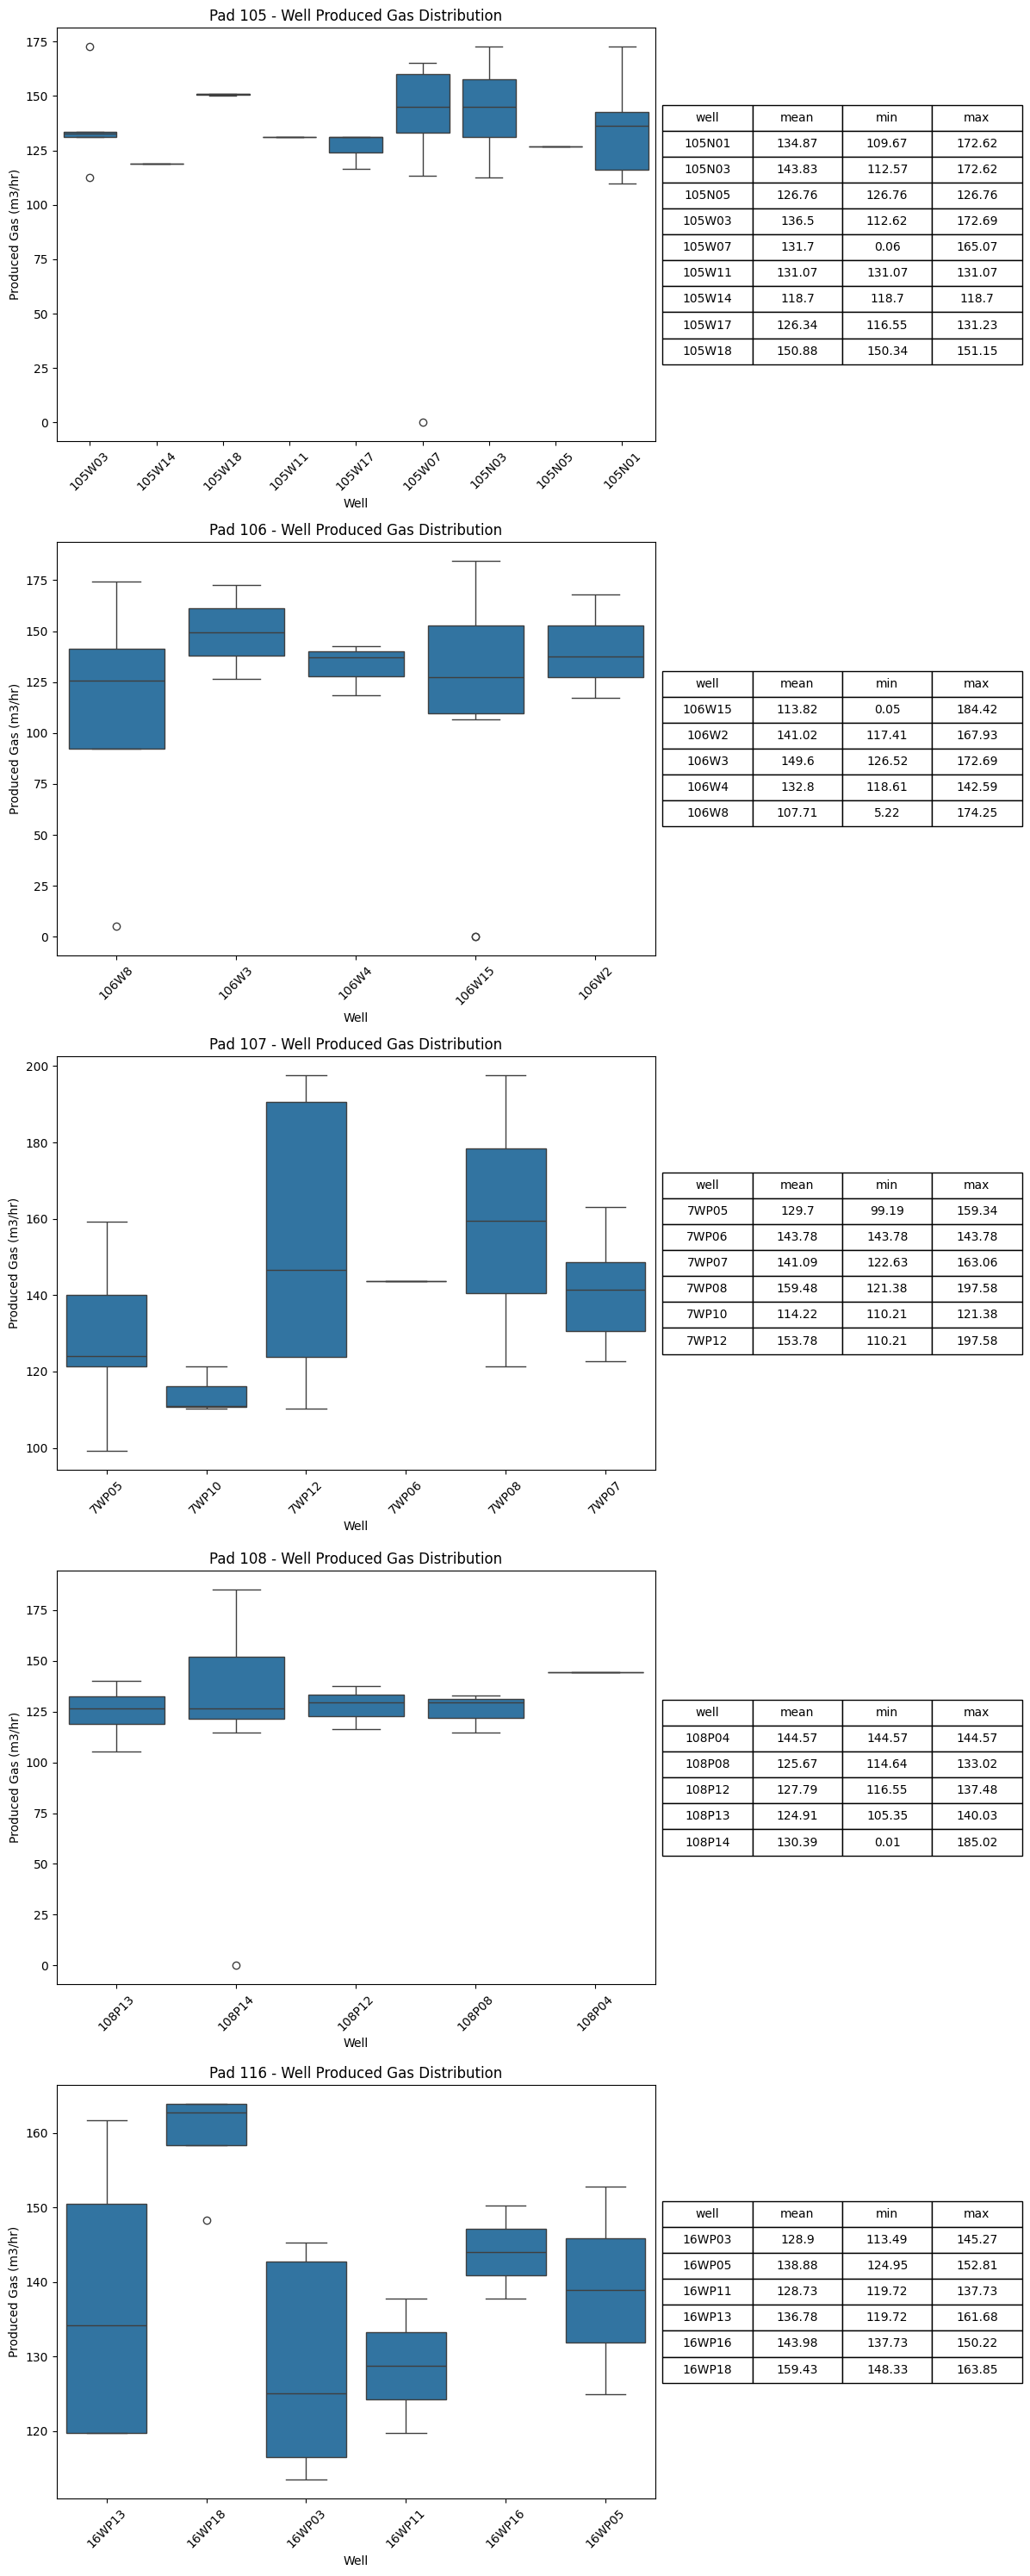

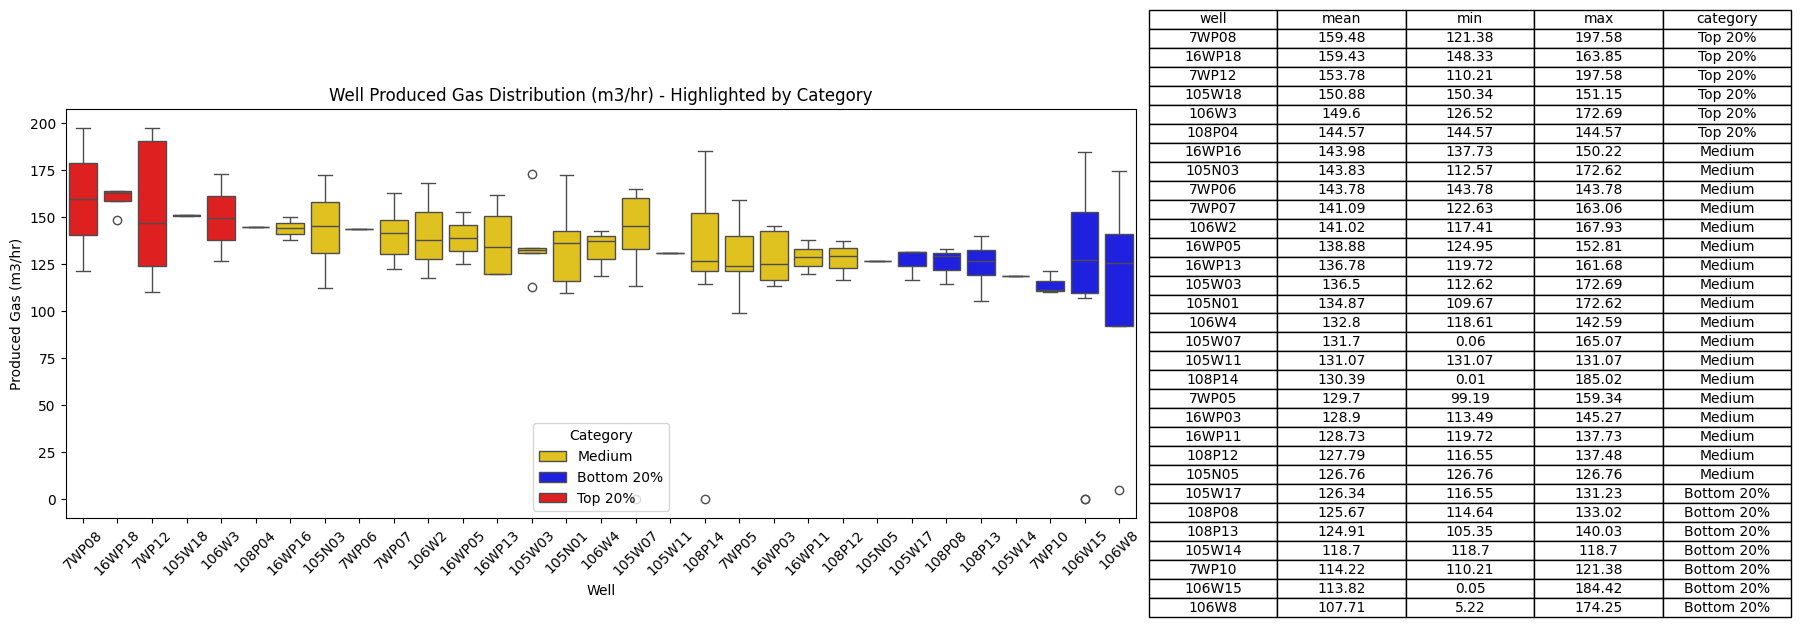

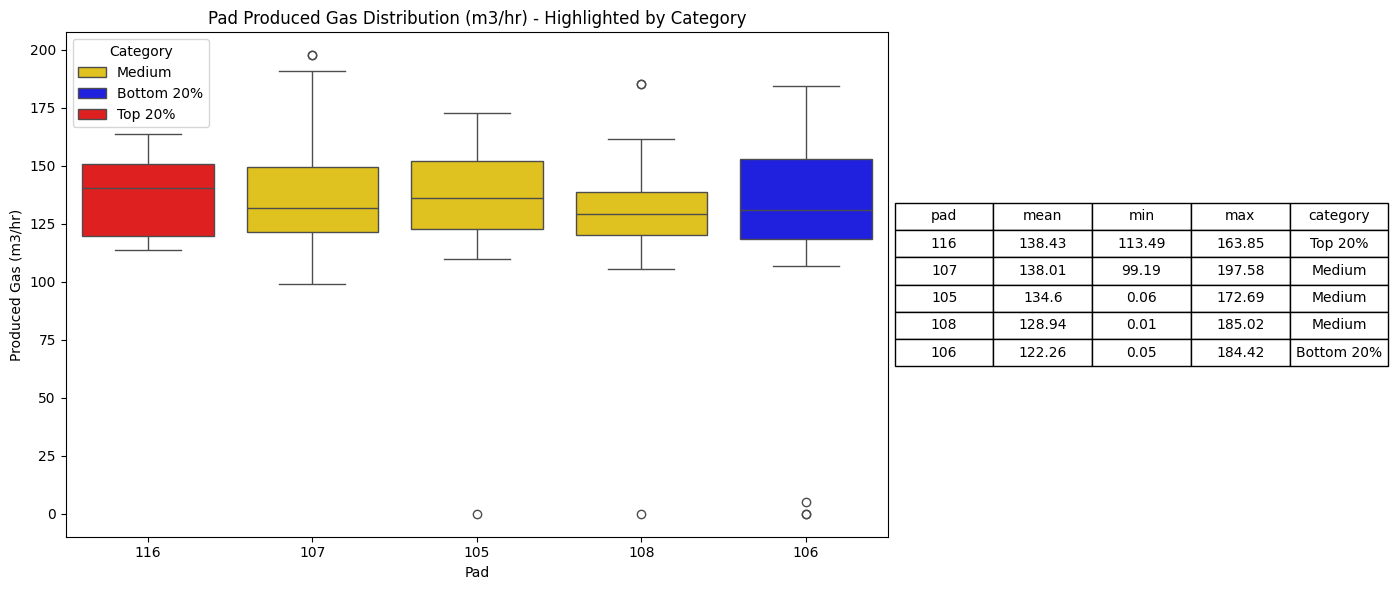

In [22]:
plot_pad_well_dashboard(df_well_pg_actual)
well_stats = get_well_stats(df_well_pg_actual)
plot_well_category_dashboard(df_well_pg_actual, well_stats)
pad_stats = get_pad_stats(df_well_pg_actual)
plot_pad_category_dashboard(df_well_pg_actual, pad_stats)